# CRNN MODEL

In [4]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
from keras import regularizers
import librosa
import librosa.display
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [1]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [1]:
npzfile = np.load('shuffled_train_.npz')
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']

npzfile = np.load('shuffled_valid_.npz')
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']


Experimental


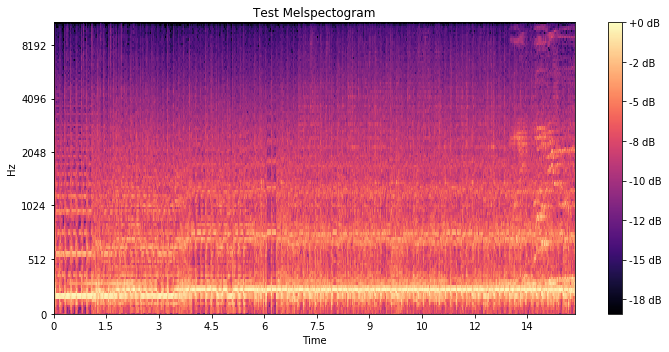

In [10]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

In [28]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [29]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    return model

def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [47]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 56)          224       
_________________________________________________________________
activation_4 (Activation)    (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 56)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None, 56)          157

6394/6394 [==============================] - 47s 7ms/step - loss: 1.4147 - acc: 0.5463 - val_loss: 1.8212 - val_acc: 0.3712

Epoch 00025: val_acc did not improve from 0.47500
Epoch 26/70
6394/6394 [==============================] - 49s 8ms/step - loss: 1.3925 - acc: 0.5599 - val_loss: 2.4693 - val_acc: 0.2825

Epoch 00026: val_acc did not improve from 0.47500
Epoch 27/70
6394/6394 [==============================] - 48s 7ms/step - loss: 1.4052 - acc: 0.5574 - val_loss: 1.8842 - val_acc: 0.3738

Epoch 00027: val_acc did not improve from 0.47500
Epoch 28/70
6394/6394 [==============================] - 48s 7ms/step - loss: 1.3917 - acc: 0.5615 - val_loss: 1.8402 - val_acc: 0.3975

Epoch 00028: val_acc did not improve from 0.47500
Epoch 29/70
6394/6394 [==============================] - 49s 8ms/step - loss: 1.3670 - acc: 0.5699 - val_loss: 1.7542 - val_acc: 0.4363

Epoch 00029: val_acc did not improve from 0.47500
Epoch 30/70
6394/6394 [==============================] - 48s 8ms/step - loss:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


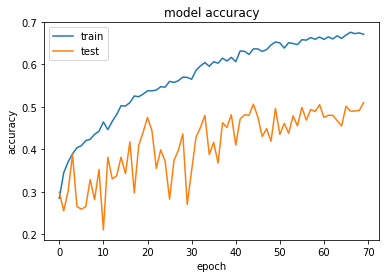

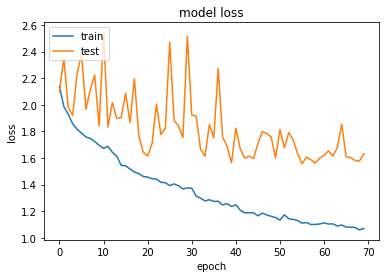

In [48]:
show_summary_stats(history)


In [49]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names = target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.42      0.62      0.50       100
 Experimental       0.47      0.67      0.55       100
         Folk       0.75      0.62      0.68       100
      Hip-Hop       0.65      0.47      0.55       100
 Instrumental       0.50      0.26      0.34       100
International       0.54      0.65      0.59       100
          Pop       0.15      0.11      0.13       100
         Rock       0.61      0.68      0.64       100

    micro avg       0.51      0.51      0.51       800
    macro avg       0.51      0.51      0.50       800
 weighted avg       0.51      0.51      0.50       800



In [50]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.51


In [2]:
from keras.models import load_model
weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

## Top two predictions - accuracy

In [11]:
from keras.models import Model
def last_layer(model_name):
    model = model_name  #include model
    layer_name = 'output_realtime' # softmax layer
    last_layer = Model(inputs = model.input, outputs = model.get_layer(layer_name).output)
    return(last_layer.predict(X_valid))

def maxim(lastlayer):
    ind_ = []
    for layer_wise in lastlayer: 
        ind = np.argpartition(layer_wise, -2)[-2:]
        ind_.append(list(ind[np.argsort(layer_wise[ind])[::-1]]))
        
    return ind_

def comparetop_two_accuracy(y_predicted, y_valid):
    decision = []
    for row_wise in range(0,len(y_valid)):
        for row_wise_ in range(0,len(y_predicted)): 
            if(row_wise == row_wise_):
                if (y_valid[row_wise] in y_predicted[row_wise_]):
                    decision.append(True)
                else: 
                    decision.append(False)
            else:
                continue 
    return(decision.count(True)/len(decision))
            


In [16]:
last_layer_op = last_layer(model)
top_two = maxim(last_layer_op)  # top two set
y_valid_int = list([np.where(r==1)[0][0] for r in y_valid]) # convert from onehot to integer

In [18]:
comparetop_two_accuracy(top_two, y_valid_int)

0.70625

In [19]:
name_top_two = [[reverse_map[b] for b in i] for i in top_two]


In [20]:
from itertools import chain
from collections import Counter
c = Counter(tuple(x) for x in iter(name_top_two))
sorted(c.items(), key=lambda pair: pair[1], reverse=True)

[(('International', 'Pop'), 78),
 (('Electronic', 'Hip-Hop'), 74),
 (('Rock', 'Pop'), 70),
 (('Experimental', 'Instrumental'), 55),
 (('Folk', 'Pop'), 51),
 (('Hip-Hop', 'Electronic'), 36),
 (('Electronic', 'Experimental'), 32),
 (('Experimental', 'Rock'), 31),
 (('Pop', 'Rock'), 25),
 (('Hip-Hop', 'International'), 24),
 (('Experimental', 'Electronic'), 23),
 (('International', 'Folk'), 22),
 (('Rock', 'Instrumental'), 21),
 (('Instrumental', 'Experimental'), 20),
 (('Folk', 'International'), 19),
 (('Experimental', 'Pop'), 19),
 (('Rock', 'Experimental'), 17),
 (('Pop', 'International'), 15),
 (('Instrumental', 'Electronic'), 15),
 (('Electronic', 'Instrumental'), 14),
 (('Electronic', 'International'), 14),
 (('Instrumental', 'Folk'), 13),
 (('Pop', 'Folk'), 12),
 (('Electronic', 'Pop'), 12),
 (('Hip-Hop', 'Pop'), 8),
 (('International', 'Electronic'), 8),
 (('International', 'Experimental'), 7),
 (('Pop', 'Electronic'), 7),
 (('Pop', 'Experimental'), 7),
 (('Pop', 'Instrumental'), 

## Connect to Test Set

In [3]:
npzfile = np.load('test_arr_.npz')
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

y_test -= 1
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)
y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()


In [80]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.60      0.59      0.60       100
 Experimental       0.30      0.41      0.35       100
         Folk       0.17      0.10      0.13       100
      Hip-Hop       0.74      0.78      0.76       100
 Instrumental       0.39      0.22      0.28       100
International       0.49      0.62      0.55       100
          Pop       0.31      0.37      0.34       100
         Rock       0.54      0.53      0.53       100

    micro avg       0.45      0.45      0.45       800
    macro avg       0.44      0.45      0.44       800
 weighted avg       0.44      0.45      0.44       800



In [66]:
y_test = keras.utils.to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)


800/800 [==============================] - 1s 2ms/step


[1.8590842628479003, 0.4525]

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[59  3  3  5  3 14  8  5]
 [12 41  5  4 13 15  6  4]
 [ 0 39 10  0 11  9 26  5]
 [ 6  5  0 78  2  6  3  0]
 [ 2 25 26  1 22  7  9  8]
 [ 5  1  7  4  1 62 15  5]
 [ 9  4  5 14  0 12 37 19]
 [ 5 18  2  0  5  2 15 53]]


In [68]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm.diagonal()

array([0.59, 0.41, 0.1 , 0.78, 0.22, 0.62, 0.37, 0.53])

In [69]:
print(accuracy_score(y_true, y_pred))

0.4525


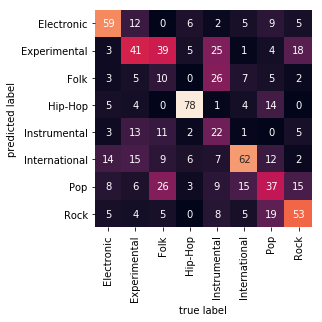

In [70]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');